# Quantifying uncertainty in Neural Networks

This is a toy regression problem to illustrate how to use a Deep Ensemble ([Lakshminarayanan 2016](https://arxiv.org/abs/1612.01474)) to estimate uncertainy on this toy regression problem.

Note that I do not use adversarial data augmentation as the paper suggests, but it seems to work alright anyway.

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import torch.nn as nn

In [2]:
def gt_func(x):
    return (10 - 0.2 * x**3 + 0.5*x - 1.2* x**2 + 0.08 * x**4) ** 0.4

In [3]:
xgt = torch.arange(-7,7,0.02)

In [4]:
ygt = gt_func(xgt)

In [5]:
xsam = torch.Tensor([-5, -4, -3.5, -0.5, 0.5, 2.5, 3, 4, 4.5])
ysam = gt_func(xsam)

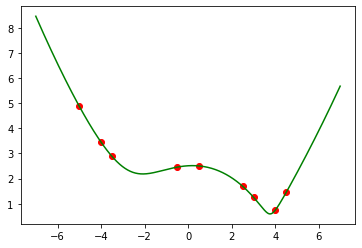

In [6]:
plt.plot(xgt,ygt, color='green')
plt.scatter(xsam, ysam, color='red')
plt.show()

In [7]:
class FC_Regress(nn.Module):
    
    def __init__(self, hidden1:int, hidden2:int):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, hidden1),
            nn.Tanh(),
            nn.Linear(hidden1, hidden2),
            nn.Tanh(),
            nn.Linear(hidden2, 1),
        )
        
    def forward(self, x:Tensor) -> Tensor:
        a = self.layers(x)
        return a

In [8]:
import regr_unc
from importlib import reload
reload(regr_unc)

<module 'regr_unc' from '/home/leo/dev/geometric-intuition/quantifying-uncertainty/regr_unc.py'>

In [9]:
def viz(net, xdata, ydata, filename:str=None):
    x = torch.arange(-7,7,0.02)
    x = x.unsqueeze(-1)
    with torch.no_grad():
        y = net(x)
        yerr = 2* net.stdev(x)
        fix = lambda a: a.cpu().view(-1).numpy()
        x = fix(x)
        y = fix(y)
        yerr = fix(yerr)

        plt.figure(figsize=(12,6))
        plt.plot(xgt,ygt, color='green')
        plt.plot(x, y, color='blue')
        plt.ylim(-4,9)
        plt.fill_between(x, y-yerr, y+yerr, color='#ccccff', alpha=0.7)
        plt.scatter(xdata, ydata, color='red')
        if filename:
            plt.savefig(filename)
        plt.show()

In [10]:
def train(xdata:Tensor, ydata:Tensor, ensemble_size:int=10, filename:str=None):
    assert len(xdata.shape) == 1
    xdata = xdata.unsqueeze(-1)
    assert len(ydata.shape) == 1
    ydata = ydata.unsqueeze(-1)
    
    torch.random.manual_seed(123)
    nets = [FC_Regress(128,128) for m in range(ensemble_size)]
    opts = [torch.optim.Adam(params=net.parameters(), lr=0.05) for net in nets]
    ensemble = regr_unc.EnsembleModel(nets)
    for e in range(300):
        for opt, net in zip(opts, nets):
            opt.zero_grad()
            yhat = net(xdata)
            loss = torch.sqrt(torch.mean((yhat-ydata)**2))
            loss.backward()
            opt.step()
        
        if int(e ** 0.5) == e ** 0.5:
            print(f"Epoch {e} loss is {loss:.3f}")
            #viz(ensemble, xdata, ydata)
    viz(ensemble, xdata, ydata, filename)

[7, 1, 5, 6, 2, 3, 8, 4, 0]
Epoch 0 loss is 0.960
Epoch 1 loss is 5.111
Epoch 4 loss is 6.360
Epoch 9 loss is 4.403
Epoch 16 loss is 3.808
Epoch 25 loss is 0.277
Epoch 36 loss is 1.669
Epoch 49 loss is 0.106
Epoch 64 loss is 3.410
Epoch 81 loss is 2.438
Epoch 100 loss is 3.401
Epoch 121 loss is 0.090
Epoch 144 loss is 1.569
Epoch 169 loss is 0.089
Epoch 196 loss is 3.395
Epoch 225 loss is 2.429
Epoch 256 loss is 3.393
Epoch 289 loss is 0.089


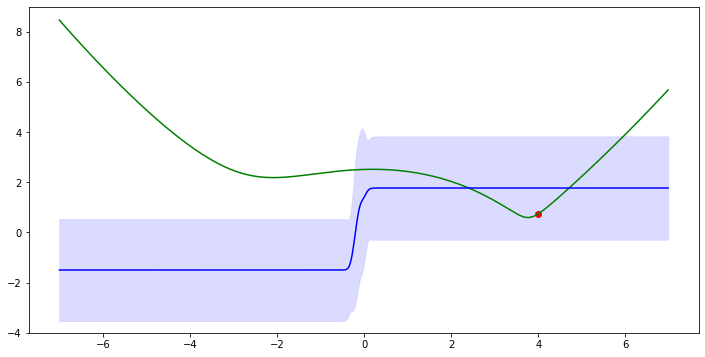

Epoch 0 loss is 2.353
Epoch 1 loss is 5.076
Epoch 4 loss is 3.793
Epoch 9 loss is 1.755
Epoch 16 loss is 1.804
Epoch 25 loss is 1.174
Epoch 36 loss is 0.303
Epoch 49 loss is 1.170
Epoch 64 loss is 0.687
Epoch 81 loss is 0.359
Epoch 100 loss is 0.567
Epoch 121 loss is 0.413
Epoch 144 loss is 0.425
Epoch 169 loss is 0.377
Epoch 196 loss is 0.410
Epoch 225 loss is 0.368
Epoch 256 loss is 0.402
Epoch 289 loss is 0.362


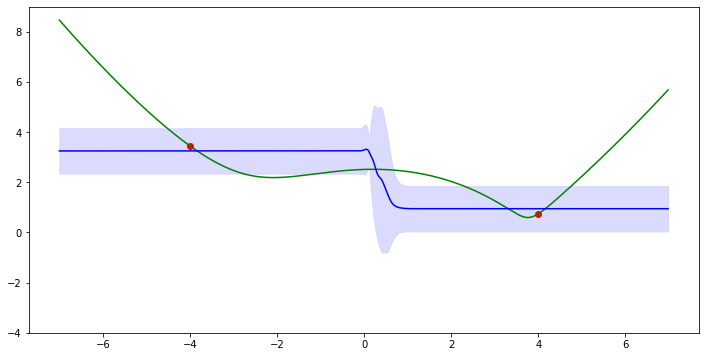

Epoch 0 loss is 2.206
Epoch 1 loss is 4.236
Epoch 4 loss is 1.965
Epoch 9 loss is 1.276
Epoch 16 loss is 0.522
Epoch 25 loss is 0.361
Epoch 36 loss is 1.373
Epoch 49 loss is 0.682
Epoch 64 loss is 0.368
Epoch 81 loss is 0.494
Epoch 100 loss is 0.653
Epoch 121 loss is 0.472
Epoch 144 loss is 0.515
Epoch 169 loss is 0.459
Epoch 196 loss is 0.645
Epoch 225 loss is 0.318
Epoch 256 loss is 0.640
Epoch 289 loss is 0.447


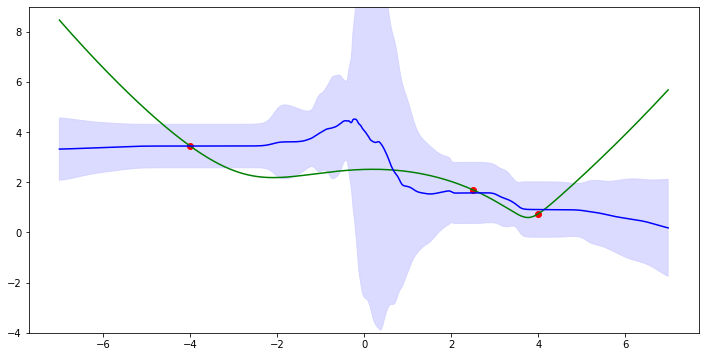

Epoch 0 loss is 2.043
Epoch 1 loss is 6.056
Epoch 4 loss is 3.845
Epoch 9 loss is 0.613
Epoch 16 loss is 0.481
Epoch 25 loss is 0.627
Epoch 36 loss is 0.495
Epoch 49 loss is 0.684
Epoch 64 loss is 0.397
Epoch 81 loss is 0.243
Epoch 100 loss is 0.260
Epoch 121 loss is 0.529
Epoch 144 loss is 0.450
Epoch 169 loss is 0.160
Epoch 196 loss is 0.291
Epoch 225 loss is 0.194
Epoch 256 loss is 0.276
Epoch 289 loss is 0.275


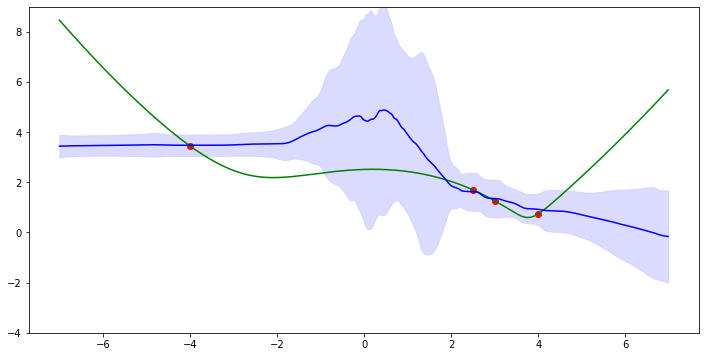

Epoch 0 loss is 2.173
Epoch 1 loss is 5.615
Epoch 4 loss is 4.447
Epoch 9 loss is 1.570
Epoch 16 loss is 0.317
Epoch 25 loss is 0.245
Epoch 36 loss is 0.224
Epoch 49 loss is 0.182
Epoch 64 loss is 0.198
Epoch 81 loss is 0.233
Epoch 100 loss is 0.248
Epoch 121 loss is 0.239
Epoch 144 loss is 0.240
Epoch 169 loss is 0.238
Epoch 196 loss is 0.238
Epoch 225 loss is 0.238
Epoch 256 loss is 0.237
Epoch 289 loss is 0.237


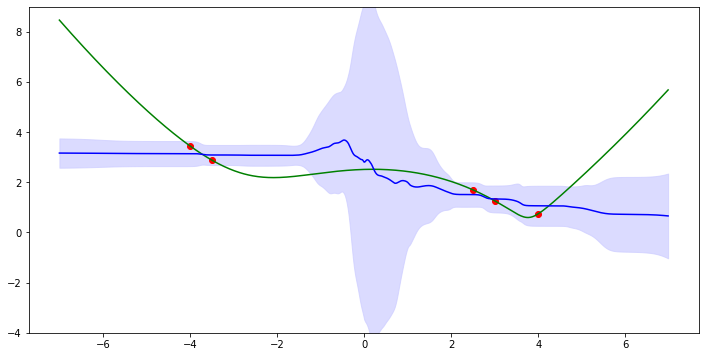

Epoch 0 loss is 2.218
Epoch 1 loss is 5.662
Epoch 4 loss is 3.384
Epoch 9 loss is 1.898
Epoch 16 loss is 0.581
Epoch 25 loss is 0.468
Epoch 36 loss is 0.336
Epoch 49 loss is 0.376
Epoch 64 loss is 0.377
Epoch 81 loss is 0.302
Epoch 100 loss is 0.335
Epoch 121 loss is 0.301
Epoch 144 loss is 0.330
Epoch 169 loss is 0.295
Epoch 196 loss is 0.326
Epoch 225 loss is 0.293
Epoch 256 loss is 0.326
Epoch 289 loss is 0.294


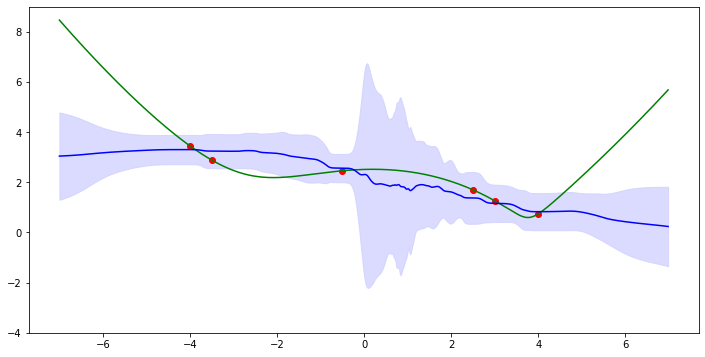

Epoch 0 loss is 2.149
Epoch 1 loss is 2.722
Epoch 4 loss is 2.618
Epoch 9 loss is 2.276
Epoch 16 loss is 0.984
Epoch 25 loss is 0.361
Epoch 36 loss is 0.277
Epoch 49 loss is 0.331
Epoch 64 loss is 0.256
Epoch 81 loss is 0.344
Epoch 100 loss is 0.335
Epoch 121 loss is 0.245
Epoch 144 loss is 0.273
Epoch 169 loss is 0.299
Epoch 196 loss is 0.564
Epoch 225 loss is 0.250
Epoch 256 loss is 0.403
Epoch 289 loss is 0.274


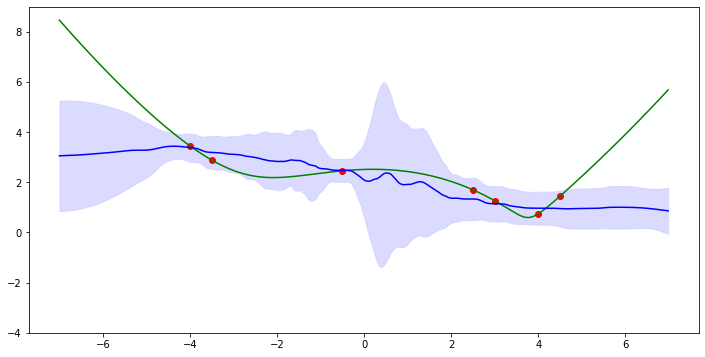

Epoch 0 loss is 2.211
Epoch 1 loss is 3.339
Epoch 4 loss is 2.919
Epoch 9 loss is 1.538
Epoch 16 loss is 0.352
Epoch 25 loss is 0.382
Epoch 36 loss is 0.310
Epoch 49 loss is 0.351
Epoch 64 loss is 0.249
Epoch 81 loss is 0.341
Epoch 100 loss is 0.354
Epoch 121 loss is 0.359
Epoch 144 loss is 0.257
Epoch 169 loss is 0.527
Epoch 196 loss is 0.405
Epoch 225 loss is 0.277
Epoch 256 loss is 0.289
Epoch 289 loss is 0.419


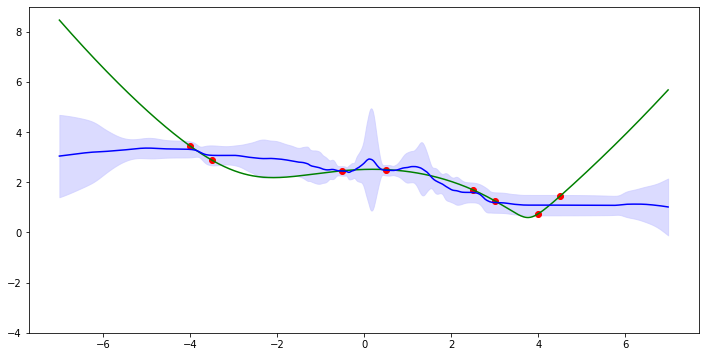

Epoch 0 loss is 2.590
Epoch 1 loss is 5.258
Epoch 4 loss is 2.805
Epoch 9 loss is 1.268
Epoch 16 loss is 0.755
Epoch 25 loss is 0.410
Epoch 36 loss is 0.212
Epoch 49 loss is 0.306
Epoch 64 loss is 0.183
Epoch 81 loss is 0.240
Epoch 100 loss is 0.576
Epoch 121 loss is 0.244
Epoch 144 loss is 0.356
Epoch 169 loss is 0.301
Epoch 196 loss is 0.214
Epoch 225 loss is 0.195
Epoch 256 loss is 0.224
Epoch 289 loss is 0.205


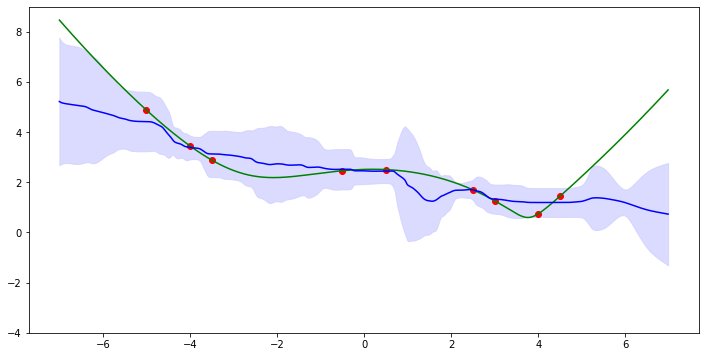

In [11]:
N = len(xsam)
#order = list(range(N))
#random.seed(123)
#random.shuffle(order)
order = [7, 1, 5, 6, 2, 3, 8, 4, 0]
print(order)
for i in range(N):
    idx = order[:(i+1)]
    x = xsam[idx]
    y = ysam[idx]
    
    train(x,y, filename=f"ensemble-{i+1}.png")